# Project 1: Molecular Dynamics with OpenMP

This assignment is due in two weeks time, by **9:30 am on Thursday October 3rd**.

**You may work in pairs on this assignment:** When you officially submit this project on Canvas, you should indicate in the text submission field on Canvas:

- Who, if anyone you are working with
- If you are working in pairs, indicater whether the repository to be graded is yours or your partner's.
- Which commit of your repository you would like to be graded (we will grade the `master` branch by default if no choice is made)

**Which type of node are you using?** Because OpenMP can be used to program the GPUs, you may choose to optimize the application for any of the three types of nodes used in this class.  Declare the type of node you would like to use here:

**This notebook should be run on a node with 28 CPU cores and 0 Tesla 0 GPUs**

If you will not use the GPUs, you should use the following modules:

In [1]:
module use $CSE6230_DIR/modulefiles
module load cse6230/core

|                                                                         |
|       A note about python/3.6:                                          |
|       PACE is lacking the staff to install all of the python 3          |
|       modules, but we do maintain an anaconda distribution for          |
|       both python 2 and python 3. As conda significantly reduces        |
|       the overhead with package management, we would much prefer        |
|       to maintain python 3 through anaconda.                            |
|                                                                         |
|       All pace installed modules are visible via the module avail       |
|       command.                                                          |
|                                                                         |


If you will use the GPUs, you should use the following modules:

In [ ]:
# module use $CSE6230_DIR/modulefiles
# module load cse6230/gcc-omp-gpu

(I've included a set of makefile rules for GNU-based builds: you can use `make MAKERULES=gcc` wherever you would use make and it should work.  You should do this if you are using the `gcc-omp-gpu` module or if you are developing on your laptop and don't have the intel compilers)

## About this program

The code for this assignment started out almost exactly the same as your third assignment with interacting particles.  We saw in that assignment the way that $O(n^2)$ interactions in an $n$-body simulation dominate the rest of the operations.  This project shows an attempt to return that work complexity from $O(n^2)$ back down to $O(n)$ or thereabouts.
  
Some of the potentials that define interactions in molecular dynamics decay *quite* rapidly.  So rapidly, that it is not a terrible approximation to assign to each particle an effective **radius $r$**.  If two particles are not touching (that is if their centers are more than $2r$ apart), then the interactions can safely be ignored (particularly if it will be drowned out relative to the background *Brownian* noise that we saw last week).  In side of $2r$, then the overlapping particles start pushing each other apart.

If you'd like to see the particulars of this assignments force due to interactions, you can look at `steric.h`, so called because the force approximate [steric effects](https://en.wikipedia.org/wiki/Steric_effects).

In [2]:
pygmentize steric.h

#if !defined(STERIC_H)
#define      STERIC_H

#include <math.h>


/* This kernel should be called if the distance between two particles is less
 * than twice the particle radius */
static inline void
force_in_range (double k, /* The interaction strength (may be scaled by the time step already) */
                double r, /* The radius of a particle.  Two particles interact if they intersect */
                double R, /* The distance between these two particles */
                double dx, double dy, double dz, /* The displacement from particle 2 to particle 1 */
                double f[3]) /* The output force exerted on particle 1 by particle 2 */
{
  /* The interaction strength starts at 0 when they are just touching,
   * becoming infinite as the distance becomes zero */
  double strength = (2. * r - R) / R;

  f[0] = k * strength * dx;
  f[1] = k * strength * dy;
  f[2] = k * strength * dz;
}

/* get the square distance and displacement between two particles under periodic
 * c

(If you find part of your program is compute bound, you are welcome to change the implementations in `steric.h`, as long as your still calculate the same function)

Now, suppose that our particles bounce around and repel each other until they are roughly in equilibrium.  We would expect that they would be well spread out, and that the chance of any two particles interacting would be no more likely than two particles placed at random.

A particle interacts with any particle within a range of $2*r$, which means that around each particle there is a sphere with volume $V_p = \frac{4}{3}\pi (2r)^3\approx 33 r^3$: any particle whose center is outside of that cell does not interact.  Suppose the volume of the periodic domain is $V_D$, and there are $N_p$ particles.  Then if the other $N_p - 1$ particles are distributed at random, then we expect $V_p (N_p - 1)/ V_D$ of those particles to interact with the particle in question.  Therefore we might expect $N_p V_p (N_p - 1) / 2 V_D$ interactions in total.

What's the point of this calculation?  Well, when run a periodic simulation, we are trying to approximate a larger domain with a fixed *density* of particles per volume.  Thus, if we consider $\phi = N_p/ V_D$ to be a fixed density of the problem we are trying to simulate, then the number of interactions is $\approx (N_p - 1) \phi / 2$.
*We should expect the number of interactions to scale linearly with the number of particles if we keep $\phi$ fixed.*

So how can we exploit the fact that only $O(N_p)$ interactions are expected instead of $O(N_p^2)$?  In our acceleration routine, we should try to rule out particles from interacting with each other.

One way to do this is *binning*: we divide up our periodic domain $[-L/2,L/2)^3$ into a grid of $b$ boxes per dimension, $b^3$ boxes total.  An algorithm would look like the following:

1. Given each particles coordinates, assign it to the appropriate box.
2. If the length of a box $(L / b)$ is longer than $2r$, then every particle can only interact with particles
  - In its own box,
  - In neighboring boxes
3. So loop over neighboring boxes and create a list of *pairs of particles* that are close enough to interact.

This is what is done now in `accelerate.c`: there is an interaction "object" that handles the internals of binning particles into boxes: it returns a list of pairs on request.

The previous $O(N_p^2)$ calculation is available for comparison and debugging purposes.

In [3]:
sed -n '54,85 p' accelerate.c | pygmentize -l c

static void
accelerate_ix (Accel accel, Vector X, Vector U)
{
  IX ix = accel->ix;
  int Np = X->Np;
  int Npairs;
  ix_pair *pairs;
  double L = accel->L;
  double k = accel->k;
  double r = accel->r;

  for (int i = 0; i < Np; i++) {
    for (int j = 0; j < 3; j++) {
      IDX(U,j,i) = 0.;
    }
  }

  IXGetPairs (ix, X, 2.*r, &Npairs, &pairs);
  for (int p = 0; p < Npairs; p++) {
    int i = pairs[p].p[0];
    int j = pairs[p].p[1];
    double du[3];

    force (k, r, L, IDX(X,0,i), IDX(X,1,i), IDX(X,2,i), IDX(X,0,j), IDX(X,1,j), IDX(X,2,j), du);

    for (int d = 0; d < 3; d++) {
      IDX(U,d,i) += du[d];
      IDX(U,d,j) -= du[d];
    }
  }
  IXRestorePairs (ix, X, 2.*r, &Npairs, &pairs);
}


## Your task

You're free to make just about any changes you'd like to the code.  The `cloud` program is currently a functioning serial program with a small amount of OpenMP already mixed in.  Below is a sequence of problems of increasing size $N_p$ but fixed density.

You should specify OpenMP environment variables before this loop that will be used by the programs.

In [ ]:
# export OMP_NUM_THREADS=...
# export OMP_PROC_BIND=...
# export OMP_SCHEDULE=...
# etc.

In [5]:
for N_p in 1 2 4 8 16 32; do
  this_L=`echo "$N_p 0.333 20." | awk '{ print ($3 * $1^$2); }'`
  this_T=`echo "$N_p 25600" | awk '{ print ($2 / ($1 * $1)); }'`
  make runcloud NP=$(( 256*$N_p )) L=$this_L NT=$this_T PERF="perf stat"
done

make --silent clean
make --silent cloud
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
perf stat ./cloud 256 25600 1.e-4 100. 1. 20 1.
[./cloud] NUM_POINTS=256, NUM_STEPS=25600, CHUNK_SIZE=25600, DT=0.0001, K=100, D=1, L=20, R=1
With 256 particles of radius 1 and a box width of 20.000000, the volume fraction is 0.134041.
The interaction volume is 33.5103, so we expect 1.07

icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
perf stat ./cloud 4096 100 1.e-4 100. 1. 50.3503 1.
[./cloud] NUM_POINTS=4096, NUM_STEPS=100, CHUNK_SIZE=100, DT=0.0001, K=100, D=1, L=50.3503, R=1
With 4096 particles of radius 1 and a box width of 50.350300, the volume fraction is 0.134413.
The interaction volume is 33.5103, so we expect 1.07531 interactions per particle, 2202.23 overall.

 Performance counter stats for './cloud 4096 100 1.e-4 100. 1. 50.3503 1.':

      11378.946088      task-clock (msec)         #    1.000 CPUs utilized          
                42      context-switches          #    0.004 K/sec                  
                 1      cpu-migrations            #    0.000 K/sec                  
               660      page-faults 

However, you code must still be correct:  an effective diffusion coefficient can be computed for the type of particles you are simulating.  The following diffusion coefficient calculation should stay in the range of 0.77-0.92:

In [2]:
make checkcloud NP=512 L=25.198421 NT=51000 CHUNK=1000

make --silent clean
make --silent cloud
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
./cloud 512 51000 1.e-4 100. 1. 25.198421 1. 1000 check | python3 check.py
Diffusion constant: [ 0.87511503]


## Grading

### 4 pts: Hassle-free usage: if the bash script that is generated by `jupyter convert` from this notebook runs without issue

### 6 pts: For code that correctly parallelizes all critical kernels (including the binning calculations in `interactions.c`)
 
- A correct diffusion coefficient is required for correctness
- If your code is not correct, points can be salvaged with *legible code* that describes what changes you are making

### 6 pts: Speed.  Any (correct) code that is the fastest on one of the benchmark problem sizes (for the node type you have selected) automatically gets 6 pts.  Code that does not outperform the initial version on any benchmark gets no points.  1 point will be available for each benchmark problem that shows non-trivial improvements in performance.

**Significant improvement is defined by the following speedups for the benchmark problems:**

- `N_p = 1`: 2x
- `N_p = 2`: 5x
- `N_p = 4, 8, 16, 32`: 9x

### 4 pts: Report.  In a cell below this one, describe the optimizations that you made and why you made them.

- Full points will require evidence (such as a screenshot) from `hpctoolkit` or some other profiling utility that motivates or justifies your changes.
- Points will be awarded for optimizations that you tried that did not work as long as you have a good explanation for why you tried them and why they didn't work.

### Report
- Step 1: run the original untouched code and view the results for each components performance in HPCVIEWER
The results :
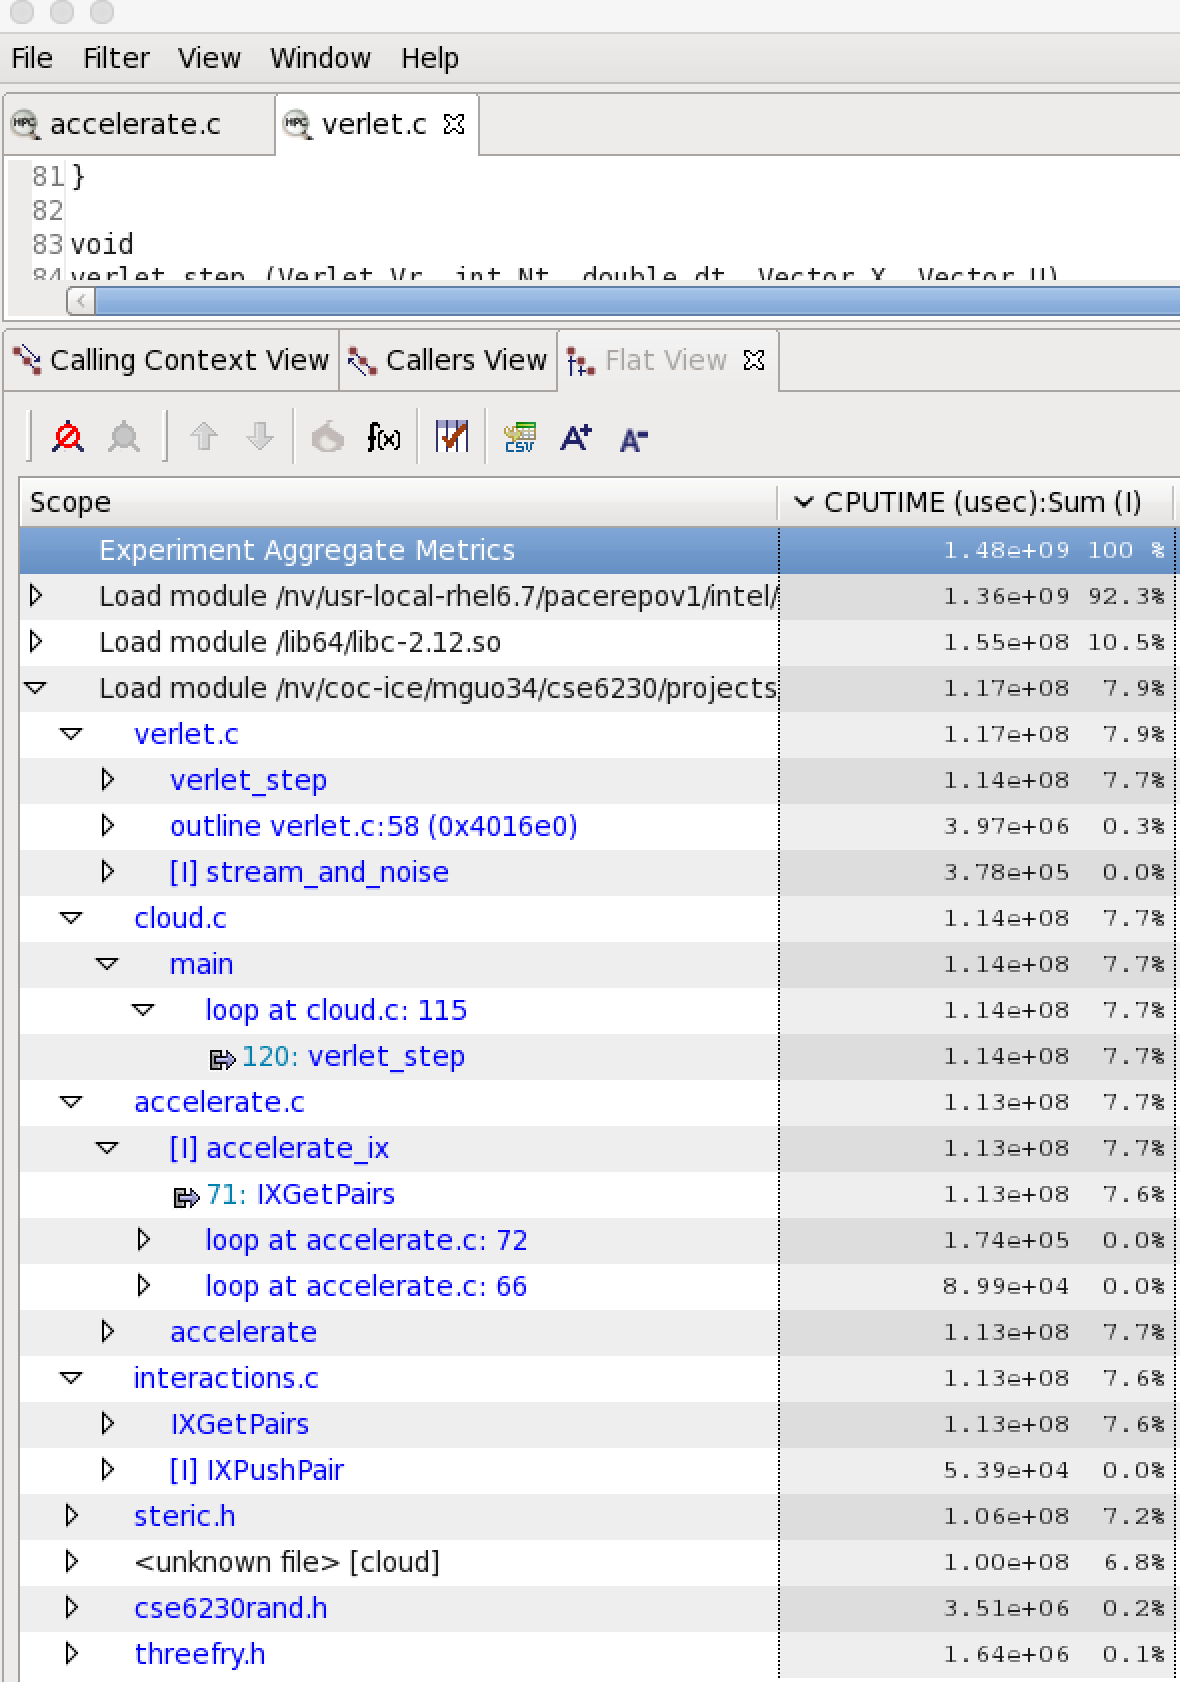

In [9]:
make clean
export OMP_NUM_THREADS=14
export OMP_PROC_BIND=spread
export OMP_SCHEDULE=static
export COPTFLAGS='-O3'
for N_p in 1 2 4 8 16 32; do
#for N_p in 1 2; do
  this_L=`echo "$N_p 0.333 20." | awk '{ print ($3 * $1^$2); }'`
  this_T=`echo "$N_p 25600" | awk '{ print ($2 / ($1 * $1)); }'`
  make runcloud NP=$(( 256*$N_p )) L=$this_L NT=$this_T PERF="perf stat"
done
make checkcloud NP=512 L=25.198421 NT=51000 CHUNK=1000

rm -f *.o cloud
make --silent clean
make --silent cloud
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
perf stat ./cloud 256 25600 1.e-4 100. 1. 20 1.
[./cloud] NUM_POINTS=256, NUM_STEPS=25600, CHUNK_SIZE=25600, DT=0.0001, K=100, D=1, L=20, R=1
With 256 particles of radius 1 and a box width of 20.000000, the volume fraction is 0.134041.
The interaction volume is 33.5103, s

icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
perf stat ./cloud 4096 100 1.e-4 100. 1. 50.3503 1.
[./cloud] NUM_POINTS=4096, NUM_STEPS=100, CHUNK_SIZE=100, DT=0.0001, K=100, D=1, L=50.3503, R=1
With 4096 particles of radius 1 and a box width of 50.350300, the volume fraction is 0.134413.
The interaction volume is 33.5103, so we expect 1.07531 interactions per particle, 2202.23 overall.

 Performance counter stats for './cloud 4096 100 1.e-4 100. 1. 50.3503 1.':

       4542.470931      task-clock (msec)         #   13.628 CPUs utilized          
               168      context-switches          #    0.037 K/sec                  
                26      cpu-migrations            #    0.006 K/sec                  
             1,332      page-faults 

In [11]:
make clean
export OMP_NUM_THREADS=14
export OMP_PROC_BIND=spread
export OMP_SCHEDULE=static
export COPTFLAGS='-O3'
make runcloud NP=512 L=25.198421 NT=51000 CHUNK=1000 PERF="hpcrun"
hpcstruct ./cloud
ll cloud.hpcstruct
hpcprof -S cloud.hpcstruct hpctoolkit-cloud-measurements-*.ice-sched.pace.gatech.edu

rm -f *.o cloud
make --silent clean
make --silent cloud
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
hpcrun ./cloud 512 51000 1.e-4 100. 1. 25.198421 1.
[./cloud] NUM_POINTS=512, NUM_STEPS=51000, CHUNK_SIZE=51000, DT=0.0001, K=100, D=1, L=25.1984, R=1
With 512 particles of radius 1 and a box width of 25.198421, the volume fraction is 0.134041.
The interaction volume is 3

13


## Advice

- **My experience in the past:** Detailed git histories are correlated with better performance!
- **Understand your code before you try to change it:**
    - In addition to profiling utilities, it might be useful to add timers to
      individual routines.  The division of the program into objects that control
      different aspects of the code should make easy to, say, add a timer
      in one place without changing the whole program.
- **Simple problem parameters that can be changed:**
    - The number of boxes per dimension
    - The layout of vectors (array-of-structures or structure of arrays? see `vector.h`)
    - The data structures used to assign particles to boxes (is a linked-list really best)?
- **Avoid memory and other resource contention:**
    - Anytime multiple threads are trying to write to locations close to each
      other, it makes it difficult and expensive to make sure each thread has
      an up-to-date copy of the memory that is changing.  This would happen,
      for example, if many threads are writing to the `pairs` list in
      the interactions routine.  Consider allocating a separate workspace for
      each thread by, for example, giving each thread its own `pairs` array.
      Then, once all threads are done computing their pairs, you can combine
      the separate arrays into one array, or even change the interface of the
      `interactions()` function so that it is multiple lists are returned.
- **Find ways to avoid recomputing from scratch:**
    - Can you use the layout of the particles from the last time step to help you
      bin or find pairs in the next time step?
- **You get to choose how many threads we use to evaluate your code:**
    - There's nothing inherently wrong with achieving your best performance
      using fewer than the maximum number of threads available on a node.  The
      problem may simply not have enough concurrency to support every thread.
- **Read through these performance slides for ideas:** [From Archer](https://www.archer.ac.uk/training/course-material/2015/12/ShMem_OpenMP_York/Slides/L09-performance.pdf)
- **Reread the molecular dynamic notes from Prof. Chow to make sure you understand what we're trying to accomplish:** [Molecular dynamics and cell lists](https://www.cc.gatech.edu/%7Eechow/ipcc/hpc-course/05_celllist.pdf)